# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [80]:
data_dir = '/data'
!pip install matplotlib==2.0.2

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'

import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

You are using pip version 9.0.1, however version 18.0 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

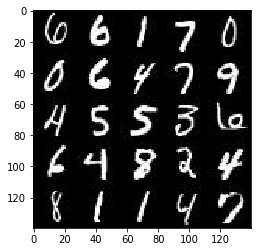

In [81]:
show_n_images = 25

%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

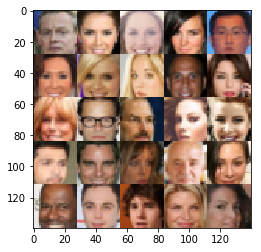

In [82]:
show_n_images = 25

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [97]:
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.3.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [98]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    learning_rate = tf.placeholder(dtype = tf.float32)
    image_input = tf.placeholder(dtype = tf.float32, shape=(None, image_height, image_width, image_channels), name="image")
    z_input = tf.placeholder(dtype = tf.float32, shape=(None, z_dim), name="z_input")
    return image_input, z_input, learning_rate

tests.test_model_inputs(model_inputs)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
['File "/opt/conda/lib/python3.6/runpy.py", line 193, in _run_module_as_main\n    "__main__", mod_spec)', 'File "/opt/conda/lib/python3.6/runpy.py", line 85, in _run_code\n    exec(code, run_globals)', 'File "/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>\n    app.launch_new_instance()', 'File "/opt/conda/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance\n    app.start()', 'File "/opt/conda/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 478, in start\n    self.io_loop.start()', 'File "/opt/conda/lib/python3.6/site-packages/zmq/eventloop/ioloop.py", line 177, in start\n    super(ZMQIOLoop, self).start()', 'File "/opt/co

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [103]:
def discriminator(images, reuse=False, alpha=0.01):
    with tf.variable_scope("discriminator", reuse=reuse):
        x1 = tf.layers.conv2d(images, 64, kernel_size = 3, strides=(2, 2), padding='same')
        x1 = tf.layers.batch_normalization(x1, training = True)
        x1 = tf.maximum(alpha*x1, x1)
        
        x2 = tf.layers.conv2d(x1, 128, kernel_size = 3, strides=(2, 2), padding='same')
        x2 = tf.layers.batch_normalization(x2, training = True)
        x2 = tf.maximum(alpha*x2, x2)
        
        x3 = tf.layers.conv2d(x2, 256, kernel_size = 3, strides=(2, 2), padding='same')
        x3 = tf.layers.batch_normalization(x3, training = True)
        x3 = tf.maximum(alpha*x3, x3)
        
        x4 = tf.reshape(x3, shape=(-1, 4*4*256))
        x4 = tf.layers.dense(x4, 1)
        logits = tf.layers.dense(x4, 1)
        output = tf.nn.sigmoid(logits)
        
    return output, logits

tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [104]:
def generator(z, out_channel_dim, is_train=True, alpha = 0.01):
    reuse = not is_train
    with tf.variable_scope("generator", reuse=reuse):
        x0 = tf.layers.dense(z, 7*7*512)
        
        x0 = tf.reshape(x0, shape=(-1, 7, 7, 512))
        x0 = tf.layers.batch_normalization(x0)
        x0 = tf.maximum(alpha*x0, x0)
        
        x1 = tf.layers.conv2d_transpose(x0, 256, kernel_size = 3, strides=(2, 2), padding='same')
        x1 = tf.layers.batch_normalization(x1)
        x1 = tf.maximum(alpha*x1, x1)
        
        x2 = tf.layers.conv2d_transpose(x1, 128, kernel_size = 3, strides=(2, 2), padding='same')
        x2 = tf.layers.batch_normalization(x2)
        x2 = tf.maximum(alpha*x2, x2)
        
        x3 = tf.layers.conv2d_transpose(x2, out_channel_dim, kernel_size = 3, strides=(1, 1), padding='same')
        x3 = tf.tanh(x3)

    return x3

tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [105]:
def model_loss(input_real, input_z, out_channel_dim):
    alpha = 0.01
    g_model_output = generator(input_z, out_channel_dim, alpha=alpha, is_train=True)
    d_fake_output, d_fake_logit = discriminator(g_model_output, alpha=alpha, reuse=False)
    d_real_output, d_real_logit = discriminator(input_real, alpha=alpha, reuse=True)
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_real_logit, labels=tf.ones_like(d_real_output)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_fake_logit, labels=tf.zeros_like(d_fake_output)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_fake_logit, labels=tf.ones_like(d_fake_output)))
    d_loss = d_loss_real + d_loss_fake
    return d_loss, g_loss

tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [106]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    return d_train_opt, g_train_opt

tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [107]:
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])
    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [108]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    steps = 0
    show_every = 100
    
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps +=1
                batch_images = batch_images * 2
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                # Run optimizers,
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                if steps % show_every == 0:
                    train_loss_d = d_loss.eval({input_real: batch_images, input_z: batch_z})
                    train_loss_g = g_loss.eval({input_z: batch_z})
                    print("Epoch {}/{}...".format(epoch_i+1, epochs),\
                          "Batch {}...".format(steps),\
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),\
                          "Generator Loss: {:.4f}".format(train_loss_g))
    
                if steps % 500 == 0:
                    show_generator_output(sess, show_n_images, input_z, data_shape[3], data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/10... Batch 100... Discriminator Loss: 0.0214... Generator Loss: 4.1829
Epoch 1/10... Batch 200... Discriminator Loss: 0.0107... Generator Loss: 4.7979
Epoch 1/10... Batch 300... Discriminator Loss: 0.4887... Generator Loss: 1.7082
Epoch 1/10... Batch 400... Discriminator Loss: 0.3752... Generator Loss: 1.9538
Epoch 1/10... Batch 500... Discriminator Loss: 0.3168... Generator Loss: 2.4833


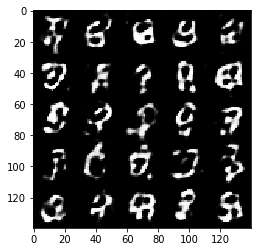

Epoch 1/10... Batch 600... Discriminator Loss: 0.4404... Generator Loss: 1.6120
Epoch 1/10... Batch 700... Discriminator Loss: 0.7346... Generator Loss: 0.9421
Epoch 1/10... Batch 800... Discriminator Loss: 1.6270... Generator Loss: 0.3813
Epoch 1/10... Batch 900... Discriminator Loss: 0.4360... Generator Loss: 2.8635
Epoch 2/10... Batch 1000... Discriminator Loss: 0.2561... Generator Loss: 2.4977


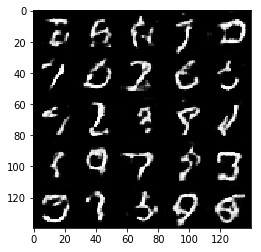

Epoch 2/10... Batch 1100... Discriminator Loss: 0.4355... Generator Loss: 1.6788
Epoch 2/10... Batch 1200... Discriminator Loss: 0.3020... Generator Loss: 2.0360
Epoch 2/10... Batch 1300... Discriminator Loss: 0.5389... Generator Loss: 1.4048
Epoch 2/10... Batch 1400... Discriminator Loss: 0.5250... Generator Loss: 1.5374
Epoch 2/10... Batch 1500... Discriminator Loss: 1.3979... Generator Loss: 0.4137


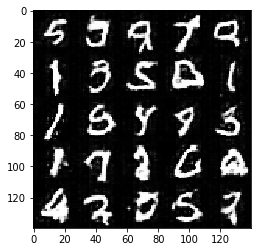

Epoch 2/10... Batch 1600... Discriminator Loss: 0.3693... Generator Loss: 1.9584
Epoch 2/10... Batch 1700... Discriminator Loss: 0.5233... Generator Loss: 1.7564
Epoch 2/10... Batch 1800... Discriminator Loss: 0.3517... Generator Loss: 2.1815
Epoch 3/10... Batch 1900... Discriminator Loss: 0.5939... Generator Loss: 1.3810
Epoch 3/10... Batch 2000... Discriminator Loss: 0.7412... Generator Loss: 2.1910


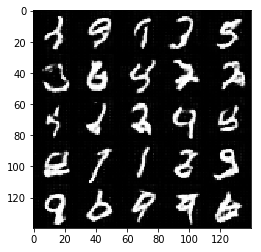

Epoch 3/10... Batch 2100... Discriminator Loss: 0.6801... Generator Loss: 1.0749
Epoch 3/10... Batch 2200... Discriminator Loss: 0.6784... Generator Loss: 1.1461
Epoch 3/10... Batch 2300... Discriminator Loss: 1.3897... Generator Loss: 0.4666
Epoch 3/10... Batch 2400... Discriminator Loss: 0.2938... Generator Loss: 2.5569
Epoch 3/10... Batch 2500... Discriminator Loss: 0.6955... Generator Loss: 1.1174


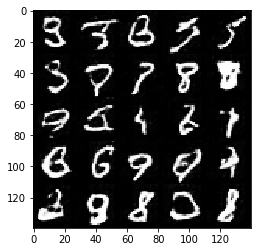

Epoch 3/10... Batch 2600... Discriminator Loss: 0.5049... Generator Loss: 1.8413
Epoch 3/10... Batch 2700... Discriminator Loss: 0.6939... Generator Loss: 1.0934
Epoch 3/10... Batch 2800... Discriminator Loss: 0.7066... Generator Loss: 2.1473
Epoch 4/10... Batch 2900... Discriminator Loss: 0.9255... Generator Loss: 0.7290
Epoch 4/10... Batch 3000... Discriminator Loss: 0.7027... Generator Loss: 1.0425


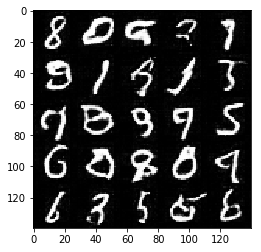

Epoch 4/10... Batch 3100... Discriminator Loss: 0.5368... Generator Loss: 1.3306
Epoch 4/10... Batch 3200... Discriminator Loss: 0.6618... Generator Loss: 1.1572
Epoch 4/10... Batch 3300... Discriminator Loss: 1.0197... Generator Loss: 0.6974
Epoch 4/10... Batch 3400... Discriminator Loss: 0.7390... Generator Loss: 0.9256
Epoch 4/10... Batch 3500... Discriminator Loss: 0.3831... Generator Loss: 1.8700


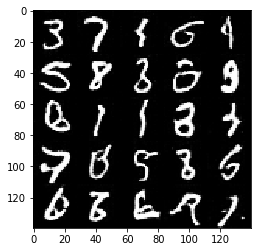

Epoch 4/10... Batch 3600... Discriminator Loss: 0.6365... Generator Loss: 1.2022
Epoch 4/10... Batch 3700... Discriminator Loss: 0.5646... Generator Loss: 1.3917
Epoch 5/10... Batch 3800... Discriminator Loss: 0.5276... Generator Loss: 1.5986
Epoch 5/10... Batch 3900... Discriminator Loss: 0.4812... Generator Loss: 1.4031
Epoch 5/10... Batch 4000... Discriminator Loss: 0.7939... Generator Loss: 1.0256


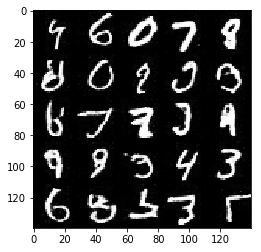

Epoch 5/10... Batch 4100... Discriminator Loss: 1.3394... Generator Loss: 0.4487
Epoch 5/10... Batch 4200... Discriminator Loss: 0.6510... Generator Loss: 1.2328
Epoch 5/10... Batch 4300... Discriminator Loss: 0.6589... Generator Loss: 1.3811
Epoch 5/10... Batch 4400... Discriminator Loss: 0.5282... Generator Loss: 1.3344
Epoch 5/10... Batch 4500... Discriminator Loss: 0.8785... Generator Loss: 0.8079


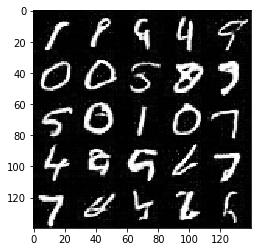

Epoch 5/10... Batch 4600... Discriminator Loss: 1.0194... Generator Loss: 0.7508
Epoch 6/10... Batch 4700... Discriminator Loss: 1.3036... Generator Loss: 0.4964
Epoch 6/10... Batch 4800... Discriminator Loss: 0.8280... Generator Loss: 1.0014
Epoch 6/10... Batch 4900... Discriminator Loss: 0.5761... Generator Loss: 1.4492
Epoch 6/10... Batch 5000... Discriminator Loss: 1.1902... Generator Loss: 0.5606


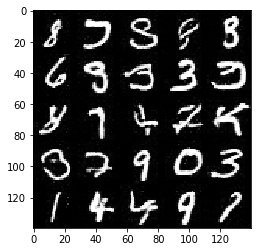

Epoch 6/10... Batch 5100... Discriminator Loss: 0.5281... Generator Loss: 1.6258
Epoch 6/10... Batch 5200... Discriminator Loss: 0.5289... Generator Loss: 1.5634
Epoch 6/10... Batch 5300... Discriminator Loss: 0.7643... Generator Loss: 0.9876
Epoch 6/10... Batch 5400... Discriminator Loss: 1.0124... Generator Loss: 0.7873
Epoch 6/10... Batch 5500... Discriminator Loss: 0.5986... Generator Loss: 1.2292


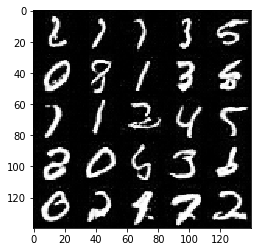

Epoch 6/10... Batch 5600... Discriminator Loss: 0.6730... Generator Loss: 1.1476
Epoch 7/10... Batch 5700... Discriminator Loss: 0.5441... Generator Loss: 1.9557
Epoch 7/10... Batch 5800... Discriminator Loss: 1.2499... Generator Loss: 0.6530
Epoch 7/10... Batch 5900... Discriminator Loss: 0.5511... Generator Loss: 1.4629
Epoch 7/10... Batch 6000... Discriminator Loss: 1.3759... Generator Loss: 0.4835


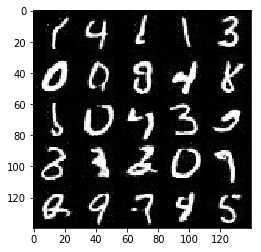

Epoch 7/10... Batch 6100... Discriminator Loss: 0.9924... Generator Loss: 0.6839
Epoch 7/10... Batch 6200... Discriminator Loss: 0.7610... Generator Loss: 1.1443
Epoch 7/10... Batch 6300... Discriminator Loss: 0.7550... Generator Loss: 1.5463
Epoch 7/10... Batch 6400... Discriminator Loss: 0.9597... Generator Loss: 0.7290
Epoch 7/10... Batch 6500... Discriminator Loss: 0.9705... Generator Loss: 0.8005


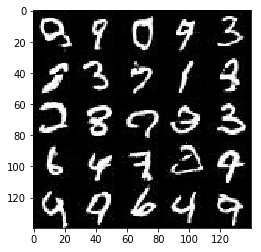

Epoch 8/10... Batch 6600... Discriminator Loss: 0.5170... Generator Loss: 1.6376
Epoch 8/10... Batch 6700... Discriminator Loss: 1.1581... Generator Loss: 2.3436
Epoch 8/10... Batch 6800... Discriminator Loss: 1.0330... Generator Loss: 0.7777
Epoch 8/10... Batch 6900... Discriminator Loss: 0.9775... Generator Loss: 0.8415
Epoch 8/10... Batch 7000... Discriminator Loss: 1.2113... Generator Loss: 0.6232


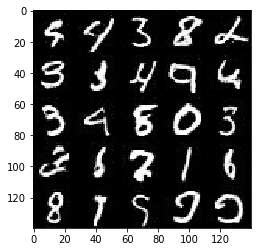

Epoch 8/10... Batch 7100... Discriminator Loss: 1.0739... Generator Loss: 0.7923
Epoch 8/10... Batch 7200... Discriminator Loss: 0.6645... Generator Loss: 1.2080
Epoch 8/10... Batch 7300... Discriminator Loss: 0.7190... Generator Loss: 1.6907
Epoch 8/10... Batch 7400... Discriminator Loss: 0.8726... Generator Loss: 0.9111
Epoch 9/10... Batch 7500... Discriminator Loss: 0.7506... Generator Loss: 1.0105


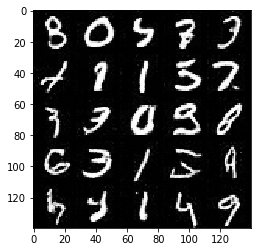

Epoch 9/10... Batch 7600... Discriminator Loss: 0.6427... Generator Loss: 1.4912
Epoch 9/10... Batch 7700... Discriminator Loss: 0.6405... Generator Loss: 1.3104
Epoch 9/10... Batch 7800... Discriminator Loss: 0.7834... Generator Loss: 0.9230
Epoch 9/10... Batch 7900... Discriminator Loss: 0.8525... Generator Loss: 2.6227
Epoch 9/10... Batch 8000... Discriminator Loss: 1.1537... Generator Loss: 0.6842


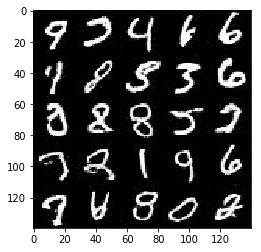

Epoch 9/10... Batch 8100... Discriminator Loss: 0.7507... Generator Loss: 1.2641
Epoch 9/10... Batch 8200... Discriminator Loss: 1.5983... Generator Loss: 0.3857
Epoch 9/10... Batch 8300... Discriminator Loss: 1.5307... Generator Loss: 0.4360
Epoch 9/10... Batch 8400... Discriminator Loss: 0.3891... Generator Loss: 2.5306
Epoch 10/10... Batch 8500... Discriminator Loss: 0.8035... Generator Loss: 1.0939


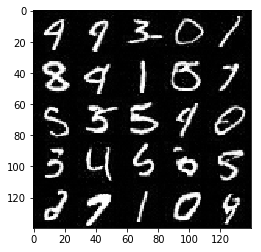

Epoch 10/10... Batch 8600... Discriminator Loss: 0.5342... Generator Loss: 1.5486
Epoch 10/10... Batch 8700... Discriminator Loss: 0.7307... Generator Loss: 1.1165
Epoch 10/10... Batch 8800... Discriminator Loss: 1.0997... Generator Loss: 0.7422
Epoch 10/10... Batch 8900... Discriminator Loss: 1.2115... Generator Loss: 0.5504
Epoch 10/10... Batch 9000... Discriminator Loss: 1.8266... Generator Loss: 0.2965


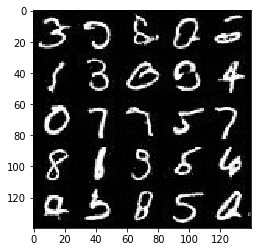

Epoch 10/10... Batch 9100... Discriminator Loss: 0.9855... Generator Loss: 1.6921
Epoch 10/10... Batch 9200... Discriminator Loss: 0.9662... Generator Loss: 0.9598
Epoch 10/10... Batch 9300... Discriminator Loss: 0.8415... Generator Loss: 0.9799


In [109]:
batch_size = 64
z_dim = 128
learning_rate = 0.0003
beta1 = 0.5

epochs = 10

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Batch 100... Discriminator Loss: 0.2001... Generator Loss: 2.1778
Epoch 1/1... Batch 200... Discriminator Loss: 0.0243... Generator Loss: 4.3595
Epoch 1/1... Batch 300... Discriminator Loss: 0.2295... Generator Loss: 2.2041
Epoch 1/1... Batch 400... Discriminator Loss: 0.7743... Generator Loss: 1.2431
Epoch 1/1... Batch 500... Discriminator Loss: 1.0498... Generator Loss: 0.6561


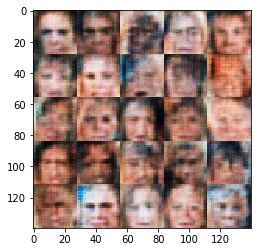

Epoch 1/1... Batch 600... Discriminator Loss: 0.9476... Generator Loss: 0.8348
Epoch 1/1... Batch 700... Discriminator Loss: 1.2401... Generator Loss: 0.5508
Epoch 1/1... Batch 800... Discriminator Loss: 1.1695... Generator Loss: 0.8773
Epoch 1/1... Batch 900... Discriminator Loss: 0.9640... Generator Loss: 0.9194
Epoch 1/1... Batch 1000... Discriminator Loss: 1.2689... Generator Loss: 0.9721


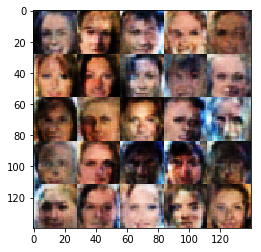

Epoch 1/1... Batch 1100... Discriminator Loss: 1.1774... Generator Loss: 0.6256
Epoch 1/1... Batch 1200... Discriminator Loss: 1.2772... Generator Loss: 0.5678
Epoch 1/1... Batch 1300... Discriminator Loss: 0.8822... Generator Loss: 1.2051
Epoch 1/1... Batch 1400... Discriminator Loss: 1.2089... Generator Loss: 0.9849
Epoch 1/1... Batch 1500... Discriminator Loss: 1.2779... Generator Loss: 0.4750


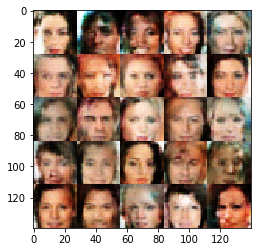

Epoch 1/1... Batch 1600... Discriminator Loss: 1.4252... Generator Loss: 0.4052
Epoch 1/1... Batch 1700... Discriminator Loss: 1.3387... Generator Loss: 0.7013
Epoch 1/1... Batch 1800... Discriminator Loss: 1.3694... Generator Loss: 0.7170
Epoch 1/1... Batch 1900... Discriminator Loss: 1.1744... Generator Loss: 0.6171
Epoch 1/1... Batch 2000... Discriminator Loss: 1.6903... Generator Loss: 0.2720


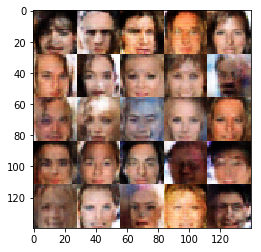

Epoch 1/1... Batch 2100... Discriminator Loss: 1.2421... Generator Loss: 0.8554
Epoch 1/1... Batch 2200... Discriminator Loss: 1.1518... Generator Loss: 0.7621
Epoch 1/1... Batch 2300... Discriminator Loss: 1.5101... Generator Loss: 0.5171
Epoch 1/1... Batch 2400... Discriminator Loss: 1.2652... Generator Loss: 0.7260
Epoch 1/1... Batch 2500... Discriminator Loss: 1.4655... Generator Loss: 0.5696


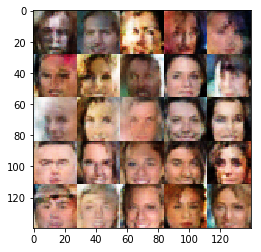

Epoch 1/1... Batch 2600... Discriminator Loss: 1.3156... Generator Loss: 0.5356
Epoch 1/1... Batch 2700... Discriminator Loss: 1.5423... Generator Loss: 0.5779
Epoch 1/1... Batch 2800... Discriminator Loss: 1.3265... Generator Loss: 0.5619
Epoch 1/1... Batch 2900... Discriminator Loss: 1.4408... Generator Loss: 0.5463
Epoch 1/1... Batch 3000... Discriminator Loss: 1.4028... Generator Loss: 0.7282


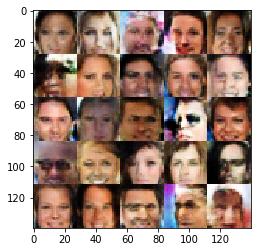

Epoch 1/1... Batch 3100... Discriminator Loss: 1.3491... Generator Loss: 0.5601


In [110]:
batch_size = 64
z_dim = 128
learning_rate = 0.0003
beta1 = 0.5

epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.